## Steam Game Analysis and Prediction

### Introduction

This project aims to conduct a predictive analysis on a public dataset encompassing over 80,000 Steam games, each containing a multitude of attributes. The primary objective is to develop a model capable of suggesting similar games based on a user's selection. For instance, if a user selects Grand Theft Auto V, the model would return a top 5 list of games most closely resembling it, such as Grand Theft Auto: San Andreas. 

By leveraging this predictive capability, we seek to enhance game recommendations for Steam users and gain deeper insights into the complex relationships between various game attributes.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from rapidfuzz import fuzz

def compare_items_with_fuzzy(df_selected):
    combinations = itertools.combinations(df_selected.unique(), 2)
    results = []

    for item1, item2 in combinations:
        similarity = fuzz.ratio(item1, item2)
        results.append([item1, item2, similarity])

    return pd.DataFrame(results, columns=['Item1', 'Item2', 'Similarity'])


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

df = pd.read_parquet("hf://datasets/FronkonGames/steam-games-dataset/data/train-00000-of-00001-e2ed184370a06932.parquet")
df.head(3)

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,Full audio languages,Reviews,Header image,Website,Support url,Support email,Windows,Mac,Linux,Metacritic score,Metacritic url,User score,Positive,Negative,Score rank,Achievements,Recommendations,Notes,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,Galactic Bowling is an exaggerated and stylize...,['English'],[],None,https://cdn.akamai.steamstatic.com/steam/apps/...,http://www.galacticbowling.net,None,None,True,False,False,0,None,0,6,11,NaN,30,0,None,0,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",[],None,https://cdn.akamai.steamstatic.com/steam/apps/...,http://trainbandit.com,None,support@rustymoyher.com,True,True,False,0,None,0,53,5,NaN,12,0,None,0,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",[],None,https://cdn.akamai.steamstatic.com/steam/apps/...,None,None,ramoncampiaof31@gmail.com,True,False,False,0,None,0,0,0,NaN,0,0,None,0,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",None,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


### EDA

For this initial analysis, we've limited the scope to the 'Categories', 'Genres', and 'Tags' columns. This is because our predictive model will primarily focus on these categorical features for game classification.

In [9]:
df = df[['Name', 'Categories', 'Genres', 'Tags']]

display("Column Type", df.dtypes)
display("Nan Quantity", df.isna().sum())
display("Duplicated Rows", sum(df.duplicated()))

'Column Type'

Name          object
Categories    object
Genres        object
Tags          object
dtype: object

'Nan Quantity'

Name              6
Categories     4456
Genres         3425
Tags          19986
dtype: int64

'Duplicated Rows'

52

All columns were initially imported as object types. To enhance performance and memory efficiency, we converted these columns to categorical data types. 

However, due to a significant presence of missing values, especially in the 'tags' column, we opted to drop this column to avoid introducing biased data. 

Additionally, duplicate rows were removed to ensure data integrity during model training.

In [10]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df.reset_index(drop=True, inplace=True)

df[df.columns] = df.apply(lambda x: x.str.strip().str.lower())
df[df.columns] = df[df.columns].astype('category')

### Analyses
#### Genre Column

The 'Genre' column exhibits a significant imbalance. While 'indie' dominates, many other genres have very low frequencies, including 'tutorial', 'movie', and 'massive multiplayer'. 

Given the substantial disparity between 'indie' and less frequent genres, considering a cutoff of approximately 10% of the maximum frequency (represented by 'action') for outlier removal might be appropriate.

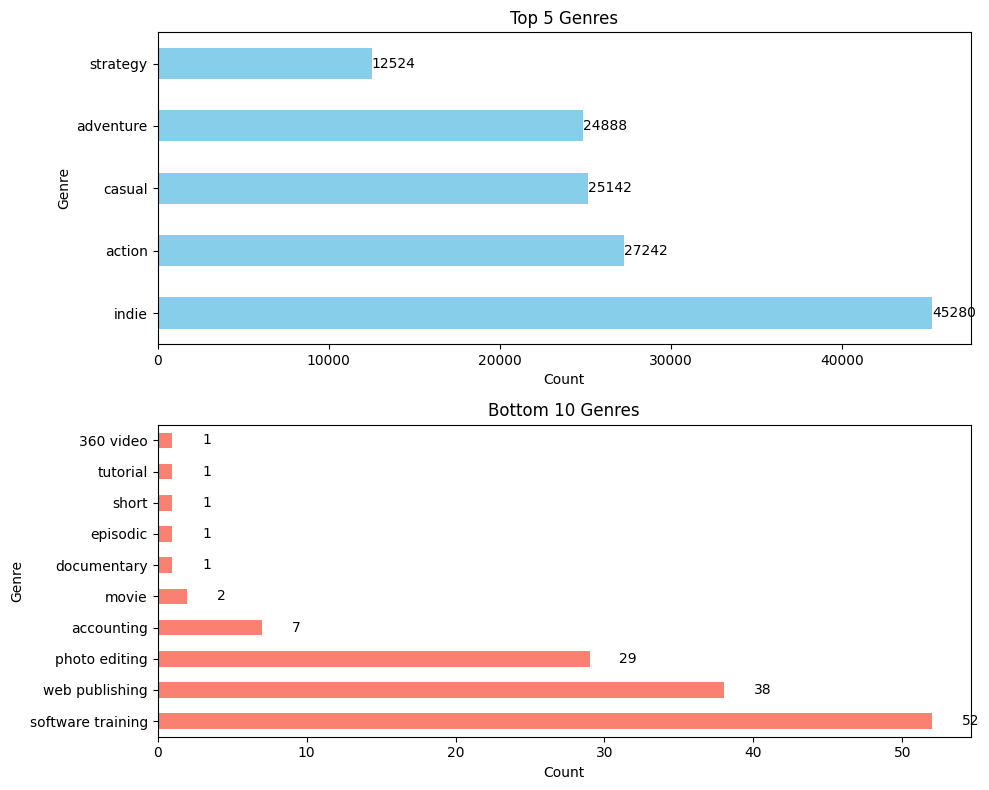

In [11]:
top_5 = df['Genres'].str.split(',').explode().value_counts().head(5)
bottom_10 = df['Genres'].str.split(',').explode().value_counts().tail(10)

fig, axes = plt.subplots(nrows=2, figsize=(10, 8))

top_5.plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_title('Top 5 Genres')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Genre')

for i, v in enumerate(top_5):
    axes[0].text(v + 2, i, str(v), color='black', va='center')

bottom_10.plot(kind='barh', ax=axes[1], color='salmon')
axes[1].set_title('Bottom 10 Genres')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Genre')

for i, v in enumerate(bottom_10):
    axes[1].text(v + 2, i, str(v), color='black', va='center')

plt.tight_layout()
plt.show()

#### Tags Column

Outliers were identified in the "Tags" column, particularly at the lower end of the data, where many values were either unique or contained only a few instances.

Additionally, over 400 unique values were found for this column. By employing RapidFuzz to assess tag similarity, we discovered several tags with similar descriptions. 

To reduce the number of unique tags and remove irrelevant outliers, these similar tags and outliers can be eliminated.

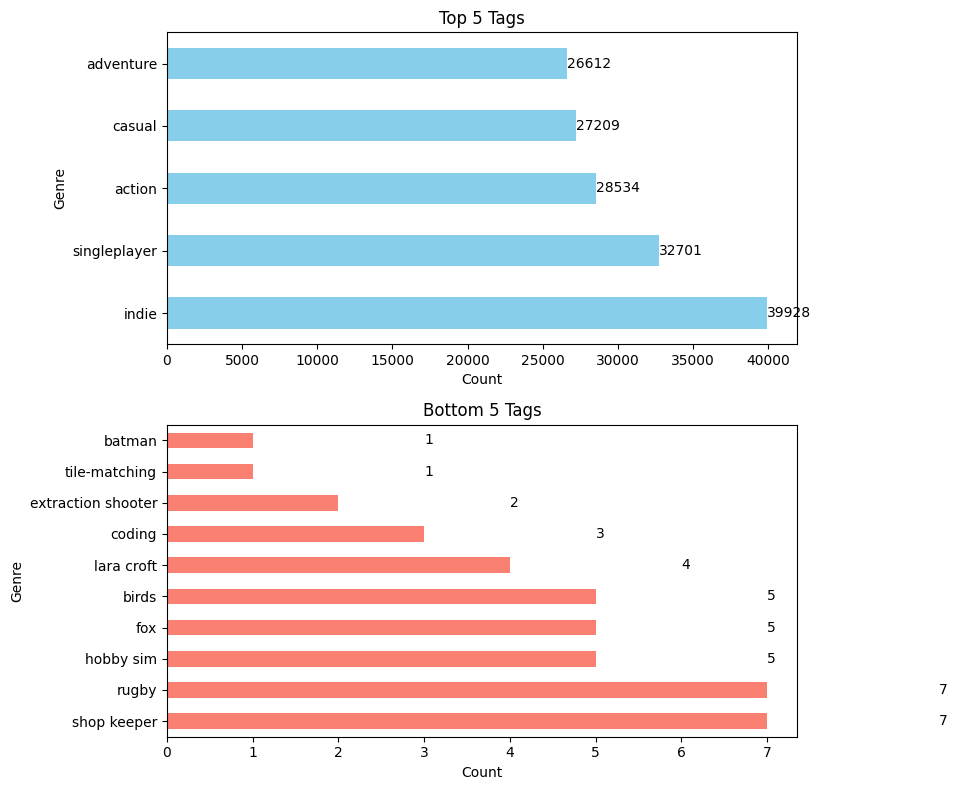

In [12]:
top_5 = df['Tags'].str.split(',').explode().value_counts().head(5)
bottom_10 = df['Tags'].str.split(',').explode().value_counts().tail(10)

fig, axes = plt.subplots(nrows=2, figsize=(10, 8))

top_5.plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_title('Top 5 Tags')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Genre')

for i, v in enumerate(top_5):
    axes[0].text(v + 2, i, str(v), color='black', va='center')

bottom_10.plot(kind='barh', ax=axes[1], color='salmon')
axes[1].set_title('Bottom 5 Tags')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Genre')

for i, v in enumerate(bottom_10):
    axes[1].text(v + 2, i, str(v), color='black', va='center')

plt.tight_layout()
plt.show()

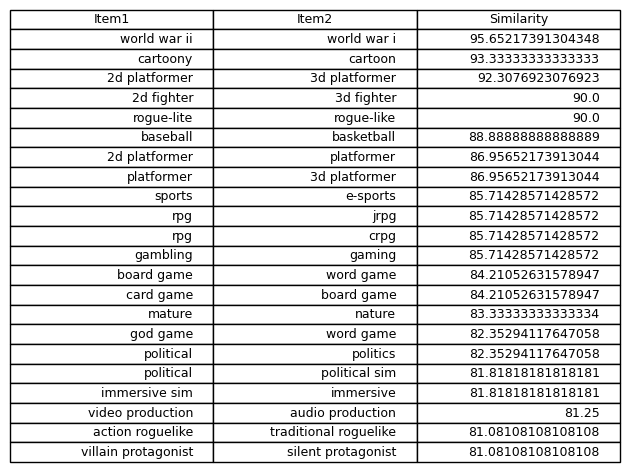

In [31]:
df_exploded = df['Tags'].str.split(',').explode()

result_comparation = compare_items_with_fuzzy(df_exploded)

result_comparation_similarity = result_comparation.loc[result_comparation['Similarity'] > 80].sort_values(by='Similarity', ascending=False)

fig, ax = plt.subplots()

fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=result_comparation_similarity.values, colLabels=result_comparation_similarity.columns, loc='center')

fig.tight_layout()

plt.show()

#### Categories Column


### Exporting File

Successfully exported the dataset after applying initial EDA treatments and exploratory analyses. Proceeding to the next phase: feature engineering.

In [77]:
df.to_csv('data/processed/data_processed.csv', index=False)